# notebook to compute final perception quotient score

In [1]:
import pandas as pd
import numpy as np

## fetch sentiment scores

sentiment scores per-username were computed with the following methods, where each tweet was labeled with positive, negative, or neutral sentiment; overall sentiment scores per user are in range $[-1,1]$

$$
\mbox{main tweets sentiment score} = \frac{\mbox{# positive sentiment-# negative sentiment}}{\mbox{total number of tweets per user}},
$$

$$
\mbox{reply tweets sentiment score} = \frac{\mbox{# positive sentiment replies-# negative sentiment replies}}{\mbox{total number of replies per user}},
$$
where replies refers to 1st and/or 2nd most popular replies to a given tweet (if they exist)

In [2]:

df_ss = pd.read_csv('/omdena_2/total_sentiment_scores.csv')
df_ss.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 507 entries, 0 to 506
Data columns (total 3 columns):
Username                 507 non-null object
Tweet Sentiment Score    507 non-null float64
Reply Sentiment Score    507 non-null float64
dtypes: float64(2), object(1)
memory usage: 12.0+ KB


## fetch language scores

Language scores per tweet were calculated from the formula,

$$
\mbox{tweet language score} = 0.4*(\mbox{z-score for coherence}) - 0.3*(\mbox{z-score for Flesch_Kincaid}) + 0.2*(\mbox{z-score for cohesion}) - 0.1*(\mbox{z-score for Gunning_Fog})
$$

So the language score per tweet is just a weighted z-score. To compute a per-username language score, the language score values for each tweet are averaged over each username.

In [3]:
df_ls = pd.read_csv("/omdena_2/language_scores_Jun_15.csv")
df_ls.columns

Index(['tweet_id', 'username', 'text', 'text_parse', 'text_cleaned',
       'Flesch_Kincaid', 'Gunning_Fog', 'coherence', 'cohesion', 'F_z', 'G_z',
       'coher_z', 'cohes_z', 'text_cleaned_2', 'language_score'],
      dtype='object')

In [8]:
df_group_ls = df_ls.groupby(['username'])

In [10]:
df_ls_per_username = df_group_ls[['F_z','G_z','coher_z','cohes_z','language_score']].mean()
df_ls_per_username = df_ls_per_username.reset_index() # converts index 'username' from groupby back into a regular column
df_ls_per_username.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 507 entries, 0 to 506
Data columns (total 6 columns):
username          507 non-null object
F_z               507 non-null float64
G_z               507 non-null float64
coher_z           507 non-null float64
cohes_z           507 non-null float64
language_score    507 non-null float64
dtypes: float64(5), object(1)
memory usage: 23.9+ KB


In [11]:
df_ls_per_username

,username,F_z,G_z,coher_z,cohes_z,language_score
0,13harmanpreet,-0.228091,-0.299630,-0.137470,-0.590598,-0.074717
1,_davidlimbrick,0.202723,0.187489,-0.146422,-0.588492,-0.255833
2,_pgauthier,-0.406884,-0.456007,-0.044151,0.590707,0.268147
3,_profanand,0.682040,0.889263,-0.066712,0.004933,-0.319236
4,aamnaisani,-0.235224,-0.185765,-0.228481,-0.118579,-0.025964
...,...,...,...,...,...,...
502,yasminqureshimp,0.579329,0.620687,-0.215577,-0.243409,-0.370780
503,yohannes_v,-0.624669,-0.502835,0.022367,0.165451,0.279721
504,yoursanjali,-0.310831,-0.454854,0.626757,0.449709,0.479379
505,ysiu,-0.016964,-0.044300,-0.409144,0.479911,-0.058156


## compute metric scores

The formula for metric score per-tweet is,

$$
\mbox{tweet metric score} = 0.25*\mbox{np.log}(1+\mbox{reply count}) + 0.25*\mbox{np.log}(1+\mbox{likes count}) + 0.25*\mbox{np.log}(1+\mbox{quote count}) + 0.25*\mbox{np.log}(1+\mbox{retweet count})
$$

To compute the metric score per username, we first find the per-tweet z-score for the metric score, then average the z-scores for each username.

In [18]:
df_rc = pd.read_csv('/omdena_2/tweets_with_reply_counts.csv')
df_rc.columns

Index(['Unnamed: 0', 'tweet_id', 'username', 'text', 'id', 'timestamp',
       'Replies', 'likes count', 'quote_tweet count', 'retweet count',
       'followers'],
      dtype='object')

In [13]:
# define a function to compute z-scores on a Pandas column; could also use scipy.stats 
# zscore(), which though does not work with np.nan values (I don't think)
def zscore_custom(in_series):
    # input a Pandas series (for example a dataframe column), or I suppose a numpy array;
    # this uses Pandas' mean() and std() handling of np.nan values--which ignores them
    # ddof=0 is to match scipy.stats zscore output--debatable if necessary
    return (in_series-in_series.mean())/in_series.std(ddof=0)

In [19]:
# use logs on all the counts for better scaling
df_rc['log_replies'] = df_rc['Replies'].apply(lambda x: np.log(x+1))
df_rc['z_log_replies'] = zscore_custom(df_rc['log_replies'])

df_rc['log_likes'] = df_rc['likes count'].apply(lambda x: np.log(x+1))
df_rc['z_log_likes'] = zscore_custom(df_rc['log_likes'])

df_rc['log_quotes'] = df_rc['quote_tweet count'].apply(lambda x: np.log(x+1))
df_rc['z_log_quotes'] = zscore_custom(df_rc['log_quotes'])

df_rc['log_retweets'] = df_rc['retweet count'].apply(lambda x: np.log(x+1))
df_rc['z_log_retweets'] = zscore_custom(df_rc['log_retweets'])


In [20]:
def weighted_sum(row):
    return 0.25*row['z_log_replies']+0.25*row['z_log_likes']+0.25*row['z_log_quotes']+0.25*row['z_log_retweets']

# metric score, per tweet
df_rc['metric_score'] = df_rc.apply(weighted_sum,axis=1)

In [21]:
df_group_ms = df_rc.groupby(['username'])
df_ms = df_group_ms[['z_log_replies','z_log_likes','z_log_quotes','z_log_retweets','metric_score']].mean()
df_ms = df_ms.reset_index()

In [22]:
df_ms.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 507 entries, 0 to 506
Data columns (total 6 columns):
username          507 non-null object
z_log_replies     507 non-null float64
z_log_likes       507 non-null float64
z_log_quotes      507 non-null float64
z_log_retweets    507 non-null float64
metric_score      507 non-null float64
dtypes: float64(5), object(1)
memory usage: 23.9+ KB


In [23]:
df_ms

,username,z_log_replies,z_log_likes,z_log_quotes,z_log_retweets,metric_score
0,13harmanpreet,-0.121673,0.599458,-0.201362,-0.054830,0.055398
1,_davidlimbrick,1.450757,1.188754,1.208777,1.013061,1.215337
2,_pgauthier,-0.505425,-0.886006,-0.366954,-0.698369,-0.614189
3,_profanand,-0.389838,-0.390940,-0.100666,0.083057,-0.199597
4,aamnaisani,0.506239,0.661929,0.019976,-0.091043,0.274275
...,...,...,...,...,...,...
502,yasminqureshimp,-0.460960,-0.342612,-0.304716,-0.270484,-0.344693
503,yohannes_v,0.039182,0.602825,0.273396,0.717837,0.408310
504,yoursanjali,0.595662,0.566111,-0.300328,0.469372,0.332704
505,ysiu,-0.695945,-0.940460,-0.365732,-0.639013,-0.660288


## merge

Load dataframe with gender and country data, and merge all of the above.

In [24]:
df_user_info = pd.read_csv('/omdena_2/NorthAmerica_Task1_1_corrected_genders_no_fan_accounts.csv')
df_user_info.columns

Index(['Unnamed: 0', 'text', 'reply1', 'reply2', 'likes count',
       'quote_tweet count', 'retweet count', 'timestamp', 'followers',
       'username', 'display name', 'gender', 'country'],
      dtype='object')

In [26]:
# this was an old dataset, that included followers, gender, and country fields for every tweet--just need 1st
# row instance for each username
df_user_info = df_user_info.groupby(['username']).first()
df_user_info = df_user_info.reset_index()
df_user_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 507 entries, 0 to 506
Data columns (total 13 columns):
username             507 non-null object
Unnamed: 0           507 non-null int64
text                 507 non-null object
reply1               506 non-null object
reply2               486 non-null object
likes count          507 non-null float64
quote_tweet count    507 non-null float64
retweet count        507 non-null float64
timestamp            507 non-null object
followers            507 non-null int64
display name         507 non-null object
gender               507 non-null object
country              507 non-null object
dtypes: float64(3), int64(2), object(8)
memory usage: 51.6+ KB


In [30]:
df_out = pd.merge(df_user_info[['username','gender','country','followers']],df_ss,how='left',
                  left_on='username',right_on='Username')
df_out.drop(['Username'],axis=1,inplace=True)
df_out.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 507 entries, 0 to 506
Data columns (total 6 columns):
username                 507 non-null object
gender                   507 non-null object
country                  507 non-null object
followers                507 non-null int64
Tweet Sentiment Score    507 non-null float64
Reply Sentiment Score    507 non-null float64
dtypes: float64(2), int64(1), object(3)
memory usage: 27.7+ KB


In [31]:
df_out = pd.merge(df_out,df_ls_per_username,how='left',on='username')
df_out.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 507 entries, 0 to 506
Data columns (total 11 columns):
username                 507 non-null object
gender                   507 non-null object
country                  507 non-null object
followers                507 non-null int64
Tweet Sentiment Score    507 non-null float64
Reply Sentiment Score    507 non-null float64
F_z                      507 non-null float64
G_z                      507 non-null float64
coher_z                  507 non-null float64
cohes_z                  507 non-null float64
language_score           507 non-null float64
dtypes: float64(7), int64(1), object(3)
memory usage: 47.5+ KB


In [32]:
df_out = pd.merge(df_out,df_ms,how='left',on='username')
df_out.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 507 entries, 0 to 506
Data columns (total 16 columns):
username                 507 non-null object
gender                   507 non-null object
country                  507 non-null object
followers                507 non-null int64
Tweet Sentiment Score    507 non-null float64
Reply Sentiment Score    507 non-null float64
F_z                      507 non-null float64
G_z                      507 non-null float64
coher_z                  507 non-null float64
cohes_z                  507 non-null float64
language_score           507 non-null float64
z_log_replies            507 non-null float64
z_log_likes              507 non-null float64
z_log_quotes             507 non-null float64
z_log_retweets           507 non-null float64
metric_score             507 non-null float64
dtypes: float64(12), int64(1), object(3)
memory usage: 67.3+ KB


In [33]:
# some checks
import matplotlib.pyplot as plt

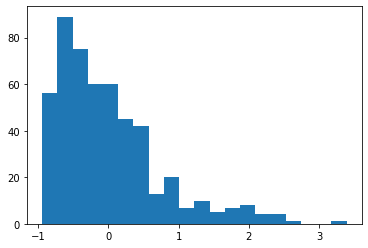

min/max: -0.9432808936920775/3.3928475170615555
middle 95 percentile:
0.05   -0.794332
0.50   -0.160475
0.95    1.581978
Name: metric_score, dtype: float64
first 90 percent of metric scores:
0.1   -0.735150
0.5   -0.160475
0.9    0.936128
Name: metric_score, dtype: float64


In [34]:
plt.hist(df_out['metric_score'],bins=20)
plt.show()
print("min/max: %s/%s" % (min(df_out['metric_score']),max(df_out['metric_score'])))
print("middle 95 percentile:")
print(df_out['metric_score'].quantile([0.05,0.5,0.95]))
print("first 90 percent of metric scores:")
print(df_out['metric_score'].quantile([0.1,0.5,0.9]))

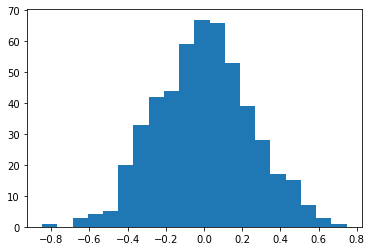

min/max: -0.8476867323616766/0.7463857663669287
middle 95 percentile:
0.05   -0.396506
0.50    0.006105
0.95    0.427133
Name: language_score, dtype: float64
first 90 percent of language scores:
0.1   -0.313616
0.5    0.006105
0.9    0.333015
Name: language_score, dtype: float64


In [35]:
plt.hist(df_out['language_score'],bins=20)
plt.show()
print("min/max: %s/%s" % (min(df_out['language_score']),max(df_out['language_score'])))
print("middle 95 percentile:")
print(df_out['language_score'].quantile([0.05,0.5,0.95]))
print("first 90 percent of language scores:")
print(df_out['language_score'].quantile([0.1,0.5,0.9]))

In [36]:
print(df_out['Tweet Sentiment Score'].quantile([0.05,0.5,0.95]))
print(df_out['Reply Sentiment Score'].quantile([0.05,0.5,0.95]))

0.05   -0.400
0.50    0.180
0.95    0.774
Name: Tweet Sentiment Score, dtype: float64
0.05   -0.44
0.50    0.10
0.95    0.67
Name: Reply Sentiment Score, dtype: float64


In [37]:
# compute final weighted sum (perception quotient)
def PQ_sum(row):
    return (0.4*row['Tweet Sentiment Score']+0.3*row['language_score']+0.25*row['metric_score']+
            0.05*row['Reply Sentiment Score'])

# metric score, per tweet
df_out['PQ_score'] = df_out.apply(weighted_sum,axis=1)

In [38]:
df_out.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 507 entries, 0 to 506
Data columns (total 17 columns):
username                 507 non-null object
gender                   507 non-null object
country                  507 non-null object
followers                507 non-null int64
Tweet Sentiment Score    507 non-null float64
Reply Sentiment Score    507 non-null float64
F_z                      507 non-null float64
G_z                      507 non-null float64
coher_z                  507 non-null float64
cohes_z                  507 non-null float64
language_score           507 non-null float64
z_log_replies            507 non-null float64
z_log_likes              507 non-null float64
z_log_quotes             507 non-null float64
z_log_retweets           507 non-null float64
metric_score             507 non-null float64
PQ_score                 507 non-null float64
dtypes: float64(13), int64(1), object(3)
memory usage: 71.3+ KB


In [39]:
df_out

,username,gender,country,followers,Tweet Sentiment Score,Reply Sentiment Score,F_z,G_z,coher_z,cohes_z,language_score,z_log_replies,z_log_likes,z_log_quotes,z_log_retweets,metric_score,PQ_score
0,13harmanpreet,Male,India,20029,0.84,0.73,-0.228091,-0.299630,-0.137470,-0.590598,-0.074717,-0.121673,0.599458,-0.201362,-0.054830,0.055398,0.055398
1,_davidlimbrick,Male,Australia,46630,-0.24,-0.47,0.202723,0.187489,-0.146422,-0.588492,-0.255833,1.450757,1.188754,1.208777,1.013061,1.215337,1.215337
2,_pgauthier,Male,France,22940,0.20,0.19,-0.406884,-0.456007,-0.044151,0.590707,0.268147,-0.505425,-0.886006,-0.366954,-0.698369,-0.614189,-0.614189
3,_profanand,Male,India,39289,-0.14,-0.17,0.682040,0.889263,-0.066712,0.004933,-0.319236,-0.389838,-0.390940,-0.100666,0.083057,-0.199597,-0.199597
4,aamnaisani,Female,Pakistan,56797,0.08,-0.01,-0.235224,-0.185765,-0.228481,-0.118579,-0.025964,0.506239,0.661929,0.019976,-0.091043,0.274275,0.274275
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
502,yasminqureshimp,Female,United Kingdom,25998,-0.34,-0.60,0.579329,0.620687,-0.215577,-0.243409,-0.370780,-0.460960,-0.342612,-0.304716,-0.270484,-0.344693,-0.344693
503,yohannes_v,Male,Australia,30979,-0.38,-0.18,-0.624669,-0.502835,0.022367,0.165451,0.279721,0.039182,0.602825,0.273396,0.717837,0.408310,0.408310
504,yoursanjali,Female,India,1370047,0.80,0.58,-0.310831,-0.454854,0.626757,0.449709,0.479379,0.595662,0.566111,-0.300328,0.469372,0.332704,0.332704
505,ysiu,Male,China,145271,0.20,0.58,-0.016964,-0.044300,-0.409144,0.479911,-0.058156,-0.695945,-0.940460,-0.365732,-0.639013,-0.660288,-0.660288


In [40]:
df_out.to_csv('/omdena_2/NorthAmerica_perception_quotient.csv',index=False)